# 🚫 Autoregressive is Not All You Need

Limitations of autoregressive models:

- **Sampling cannot be parallelized**  
  (tokens are generated one by one, slowing inference)

- **Error accumulation**  
  (small mistakes in early steps compound downstream)

- **Train–test distribution mismatch**  
  (teacher forcing vs. free-running decoding)

- **Assumes time-invariant conditional distributions**  
  $$
  p(x_t \mid x_1, \ldots, x_{t-1}) \;\approx\; p(x_{t+1} \mid x_2, \ldots, x_t)
  $$

- **Continuous data?**  
  (autoregression is naturally discrete)

- **No compressed representation**  
  - Can compress a *dataset* (probability model)  
  - But not a *single data point* (no latent code)

---

👉 This motivates **Variational Autoencoders (VAEs)**, which *learn a compressed latent representation* while still modeling complex data distributions.


# 🌌 Latent Variable Models

- **High-dimensional data** (e.g., images) often lies near a much **lower-dimensional manifold**.  
![manifold](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-020-14578-5/MediaObjects/41467_2020_14578_Fig1_HTML.png)

- Introduce a hidden (latent) variable **z** that captures the **key factors of variation**:  
  - gender, pose, age, hair color, race, etc.  
- These factors are usually **not observed** in the dataset (unless explicitly annotated).

![latent variable](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSX963YvC_jQSf5JmjpbVin9x-731iIQfd-DA&s)

---

### Generative Process

We define a latent variable model:

$$
p_\theta(x) = \int p_\theta(z) \, p_\theta(x \mid z) \, dz
$$

- Prior over latents:  
  $$
  p_\theta(z) \;\;=\;\; {N}(0, I)
  $$
  (simple, isotropic Gaussian)

- Conditional likelihood (decoder):  
  $$
  p_\theta(x \mid z) \;\;=\;\; \text{simple distribution, e.g. } {N}\big(f_\theta(z), \sigma^2 I\big)
  $$

---

### Intuition
- The **deep neural network decoder** $f_\theta(z)$ maps latent codes to high-dimensional data.  
- Goal: Learn a **compressed representation** that explains the data through simple latent priors and decoders.

![Sampling](https://hackernoon.imgix.net/images/BOZm3S9K10QSsDqaAo9E4AmSruG3-f2w2ueb.png)

## How does the latent variable models model the Joint Distribution
We want to model the distribution of high-dimensional data $x \in \mathbb{R}^D$.

$$
p_\theta(x) \;=\; \int p(z)\, p_\theta(x \mid z)\, dz
$$

- Latent variable $z \in \mathbb{R}^d$, with $d \ll D$.
- **Simple prior**:  
  $$
  p(z) = {N}(0, I)
  $$
- **Factorized conditional likelihood**:  
  $$
  p_\theta(x \mid z) = \prod_{i=1}^D p_\theta(x_i \mid z)
  $$

This makes the decoder tractable: each $x_i$ depends only on the latent code $z$.

---

## 2. Optimizing the Model
The challenge:  
- Directly maximizing $\log p_\theta(x)$ requires integrating over all possible $z$.  
- This **integral is intractable** for high dimensions.  
- We need an **approximation strategy** → this leads to *variational inference* and eventually **VAEs**.


# 📉 Evidence Lower Bound (ELBO)

## The Challenge
We want to maximize the log-likelihood of the data:
$$
\log p_\theta(x) = \log \int p(z)\, p_\theta(x \mid z)\, dz
$$

But this integral is **intractable**.

---

## Variational Inference
- Introduce an **approximate posterior** $q_\phi(z \mid x)$ (encoder).  
- Rewrite using importance sampling:
$$
\log p_\theta(x) = \log \int q_\phi(z \mid x) \frac{p(z)\, p_\theta(x \mid z)}{q_\phi(z \mid x)} \, dz
$$

---

## Jensen’s Inequality → Lower Bound
$$
\log p_\theta(x)
\;\geq\;
\mathbb{E}_{z \sim q_\phi(z \mid x)}
\big[ \log p_\theta(x \mid z) \big]
- \mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big)
$$

This is the **Evidence Lower Bound (ELBO):**

- **Reconstruction term**: likelihood of data given latent  
- **Regularization term**: KL divergence between encoder and prior

---

## Optimization Goal
Maximize the ELBO w.r.t. both:
- $\theta$: decoder parameters  
- $\phi$: encoder parameters  

This makes the model both **generative** (decoder) and **inference-capable** (encoder).


## 🧠 Deeper Intuition: Reconstruction vs. Regularization

Recall the ELBO:
$$
\text{ELBO}(x) =
\underbrace{\mathbb{E}_{z \sim q_\phi(z \mid x)}
\big[ \log p_\theta(x \mid z) \big]}_{\text{Reconstruction term}}
-
\underbrace{\mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big)}_{\text{Regularization term}}
$$

---

### 🔹 First Term: Reconstruction
- **What it does**:  
  Encourages the decoder $p_\theta(x \mid z)$ to output data that is close to the input $x$.  
- **Why important**:  
  If this term is large, it means the VAE is good at "remembering" and **reconstructing** the dataset.  
- **Analogy**:  
  Think of $z$ as a compressed JPEG image and the decoder as the JPEG **decompressor** — this term ensures the decompressed image looks like the original.  
- **If ignored**:  
  The latent space might look neat, but the model won’t actually generate realistic data.

---

### 🔹 Second Term: Regularization
- **What it does**:  
  Penalizes the encoder $q_\phi(z \mid x)$ if it assigns each datapoint a wildly different latent distribution that strays from the prior $p(z)$.  
- **Why important**:  
  Keeps the latent codes "organized" around a simple prior (like ${N}(0,I)$), so the latent space is **smooth and continuous**.  
- **Analogy**:  
  Imagine a library: without regularization, every book is randomly shelved, making it impossible to find things. With regularization, all books follow a common system (Dewey Decimal, etc.), so you can easily navigate.  
- **If ignored**:  
  The encoder might memorize each data point separately → poor generalization and *nonsense* samples when drawing new $z \sim p(z)$.

---

✅ Together:  
- **Reconstruction** makes sure the model learns the data.  
- **Regularization** makes sure the model learns a *useful latent space* that supports generation and interpolation.



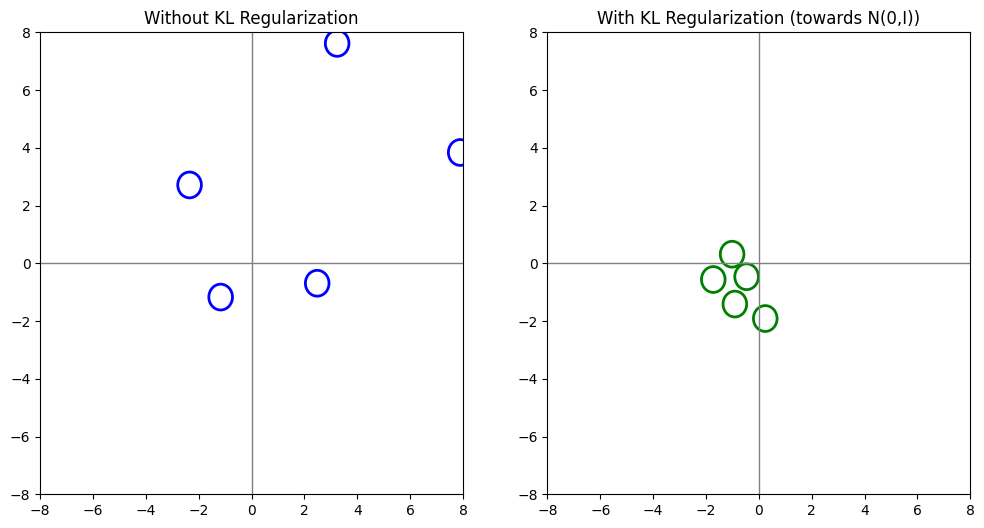

In [6]:
# 🎨 Visualizing the Effect of KL Regularization in a VAE

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Function to draw Gaussian ellipses
def draw_gaussian(ax, mean, cov, color, label=None):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height,
                      angle=angle, edgecolor=color, fc='None', lw=2, label=label)
    ax.add_patch(ellipse)

# Simulated encoders (without and with regularization)
np.random.seed(42)
means_no_reg = np.random.randn(5, 2) * 5    # encoder puts points far apart
covs_no_reg = [np.eye(2) * 0.2 for _ in range(5)]

means_reg = np.random.randn(5, 2) * 1.0     # encoder distributions cluster near 0
covs_reg = [np.eye(2) * 0.2 for _ in range(5)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Without KL regularization
axes[0].set_title("Without KL Regularization")
for m, c in zip(means_no_reg, covs_no_reg):
    draw_gaussian(axes[0], m, c, "blue")
axes[0].set_xlim(-8, 8)
axes[0].set_ylim(-8, 8)
axes[0].axhline(0, color='gray', lw=1)
axes[0].axvline(0, color='gray', lw=1)

# With KL regularization
axes[1].set_title("With KL Regularization (towards N(0,I))")
for m, c in zip(means_reg, covs_reg):
    draw_gaussian(axes[1], m, c, "green")
axes[1].set_xlim(-8, 8)
axes[1].set_ylim(-8, 8)
axes[1].axhline(0, color='gray', lw=1)
axes[1].axvline(0, color='gray', lw=1)

plt.show()


![Math](https://craigball.net/wp-content/uploads/2019/10/warning-math.png)

# ✨ From Jensen’s Inequality to the ELBO

We start with the intractable marginal likelihood:
$$
\log p_\theta(x) = \log \int p(z)\,p_\theta(x \mid z)\,dz
$$

---

## Step 1: Introduce an approximate posterior
Multiply and divide by $q_\phi(z \mid x)$:
$$
\log p_\theta(x)
= \log \int q_\phi(z \mid x)\,
   \frac{p(z)\,p_\theta(x \mid z)}{q_\phi(z \mid x)} \, dz
$$

---

## Step 2: Apply Jensen’s inequality
$$
\log \mathbb{E}_{z \sim q_\phi(z \mid x)}
   \Bigg[\frac{p(z)\,p_\theta(x \mid z)}{q_\phi(z \mid x)}\Bigg]
\;\;\geq\;\;
\mathbb{E}_{z \sim q_\phi(z \mid x)}
   \Bigg[\log \frac{p(z)\,p_\theta(x \mid z)}{q_\phi(z \mid x)}\Bigg]
$$

---

## Step 3: Expand the terms
$$
\mathbb{E}_{z \sim q_\phi(z \mid x)}
   [\log p_\theta(x \mid z)]
+ \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log p(z)]
- \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log q_\phi(z \mid x)]
$$

---

## Step 4: Recognize the KL divergence
$$
\mathbb{E}_{z \sim q_\phi(z \mid x)}
   [\log p_\theta(x \mid z)]
- \mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big)
$$

---

## 🔑 Interpretation
- **First term (Reconstruction)**  
  Encourages the decoder $p_\theta(x \mid z)$ to reconstruct the data well.  

- **Second term (Regularization)**  
  Penalizes the encoder $q_\phi(z \mid x)$ if it drifts too far from the prior $p(z)$.  

---

✅ Together, this forms the **Evidence Lower Bound (ELBO)**:
$$
\log p_\theta(x) \;\geq\;
\mathbb{E}_{z \sim q_\phi(z \mid x)}
\big[ \log p_\theta(x \mid z) \big]
- \mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big)
$$


# 🔄 ELBO and the True Posterior

We can also connect the ELBO to the **true posterior** $p_\theta(z \mid x)$.

---
# 📐 log pθ(x) = ELBO(x) + KL(qϕ ∥ pθ)?

---

## Step 1: Start from Bayes’ rule
$$
p_\theta(z \mid x) = \frac{p_\theta(x,z)}{p_\theta(x)}.
$$

---

## Step 2: Write the KL divergence
$$
\mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p_\theta(z \mid x)\big)
= \mathbb{E}_{z \sim q_\phi(z \mid x)}
   \left[\log \frac{q_\phi(z \mid x)}{p_\theta(z \mid x)}\right].
$$

Substitute Bayes’ rule:
$$
= \mathbb{E}_{z \sim q_\phi(z \mid x)}
   \left[\log \frac{q_\phi(z \mid x)}{p_\theta(x,z) / p_\theta(x)}\right].
$$
---

## Step 3: Separate the terms
$$
= \mathbb{E}_{z \sim q_\phi(z \mid x)}
   \left[\log \frac{q_\phi(z \mid x)}{p_\theta(x,z)}\right]
   + \log p_\theta(x).
$$

---

## Step 4: Rearrange
From Step 3 we had:
$$
\mathrm{KL}(q_\phi(z \mid x)\,\|\,p_\theta(z \mid x))
= \mathbb{E}_{z \sim q_\phi(z \mid x)}\!\left[\log \frac{q_\phi(z \mid x)}{p_\theta(x,z)}\right] + \log p_\theta(x).
$$

Rearrange to isolate $\log p_\theta(x)$:
$$
\log p_\theta(x)
= \mathbb{E}_{z \sim q_\phi(z \mid x)}
   \Bigg[\log \frac{p_\theta(x,z)}{q_\phi(z \mid x)}\Bigg]
+ \mathrm{KL}\!\big(q_\phi(z \mid x)\,\|\,p_\theta(z \mid x)\big).
$$


---

## Step 5: Recognize the pieces
- The expectation term is the **ELBO**:
$$
\text{ELBO}(x) = \mathbb{E}_{z \sim q_\phi(z \mid x)}
   \Big[ \log p_\theta(x \mid z)\Big] - \mathrm{KL}(q_\phi(z \mid x) \,\|\, p(z)).
$$

- The second term is the **posterior gap**:
$$
\mathrm{KL}\!\big(q_\phi(z \mid x)\,\|\, p_\theta(z \mid x)\big) \geq 0.
$$

---

## ✅ Final Identity
$$
\log p_\theta(x) = \text{ELBO}(x) +
\mathrm{KL}\!\big(q_\phi(z \mid x)\,\|\, p_\theta(z \mid x)\big)
$$

- Maximizing the **ELBO** makes $q_\phi(z \mid x)$ close to the true posterior.  
- Since KL is always nonnegative, the ELBO is a **tight lower bound** on $\log p_\theta(x)$.  


# 🤖 Variational Autoencoders (VAEs)

We now combine everything into the **VAE training objective**.

![VAE](https://www.math.emory.edu/site/cmds-reuret/projects/2024-vae/VAE_2.png)

---

## VAE Loss Function
Minimize (negative ELBO):
$$
\min_{\theta, \phi} \;
- \mathbb{E}_{z \sim q_\phi(z \mid x)} \big[\log p_\theta(x \mid z)\big]
+ \mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big)
$$

- **First term (Reconstruction loss):**  
  Forces the decoder $p_\theta(x \mid z)$ to accurately reconstruct the input.  
  In practice, this is often a squared error loss (for continuous data) or cross-entropy loss (for binary data).

- **Second term (KL regularization):**  
  Keeps the encoder distribution $q_\phi(z \mid x)$ close to the prior $p(z)$, ensuring a smooth latent space.

---

## 🔗 Connection to the ELBO
- The ELBO was a **lower bound** on the log-likelihood $\log p_\theta(x)$.  
- Maximizing the ELBO ↔ Minimizing the negative ELBO (the loss above).  
- This gives VAEs a **principled probabilistic foundation**:
  - Encoder = variational approximation $q_\phi(z \mid x)$  
  - Decoder = generative model $p_\theta(x \mid z)$
  - Training = maximize ELBO ≈ maximize data likelihood

---

✅ The VAE is therefore both:
- a **latent variable generative model** (via decoder), and  
- an **inference model** (via encoder).


# 🔧 Reconstruction Loss in a VAE

The reconstruction loss comes from the **negative expected log-likelihood**:
$$
{L}_{\text{rec}}(x) =
- \mathbb{E}_{z \sim q_\phi(z \mid x)}
    \big[ \log p_\theta(x \mid z) \big].
$$

---

## 1. How do we evaluate $\log p_\theta(x \mid z)$?
We need to choose a **likelihood model** for the decoder.

- For continuous data (e.g., images with pixel intensities):  
  Assume a Gaussian likelihood:
  $$
  p_\theta(x \mid z) = {N}\big(x \,\mid\, \mu_\theta(z), \sigma^2 I \big).
  $$

---

## 2. Log-likelihood under Gaussian
For a Gaussian with fixed variance $\sigma^2$:
$$
\log p_\theta(x \mid z)
= -\frac{1}{2\sigma^2} \|x - \mu_\theta(z)\|^2 + \text{const}.
$$

---

## 3. Monte Carlo Estimation
Since $z \sim q_\phi(z \mid x)$, we approximate the expectation using samples of $z$:

$$
{L}_{\text{rec}}(x) \;\approx\;
\frac{1}{2\sigma^2} \|x - \mu_\theta(z)\|^2.
$$

- This is essentially a **mean squared error (MSE)** loss between the input $x$ and the reconstruction $\mu_\theta(z)$.  
- In practice, we often set $\sigma^2 = 1$ and directly use MSE.

---

## 🔑 Intuition
- The encoder $q_\phi(z \mid x)$ provides a latent sample $z$.  
- The decoder $p_\theta(x \mid z)$ predicts a reconstruction $\mu_\theta(z)$.  
- The reconstruction loss measures **how close the reconstruction is to the original data**.

---


# ⚖️ Regularization Loss (KL Loss)

The second part of the VAE objective is the **KL divergence**:
$$
{L}_{\text{KL}}(x) \;=\;
\mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big).
$$

---

## 1. Choice of distributions
- Prior:  
  $$
  p(z) = {N}(0, I)
  $$

- Encoder (variational posterior):  
  $$
  q_\phi(z \mid x) = {N}\!\big(\mu_\phi(x), \, \text{diag}(\sigma_\phi^2(x))\big)
  $$

This Gaussian form makes the KL divergence **tractable**.

---

## 2. KL divergence between two Gaussians
For $q = {N}(\mu, \sigma^2 I)$ and $p = {N}(0, I)$:
$$
\mathrm{KL}(q \,\|\, p) \;=\;
\frac{1}{2} \sum_{j=1}^d
\Big( \sigma_j^2 + \mu_j^2 - 1 - \log \sigma_j^2 \Big).
$$

- Depends only on encoder outputs $\mu_\phi(x)$ and $\sigma_\phi(x)$.  
- No sampling required → computed in closed form.

---

## 3. Intuition
- This loss penalizes the encoder if it pushes latent codes **too far from the prior**.  
- Ensures the latent space remains smooth and close to ${N}(0, I)$.  
- Without this term, each data point could get its own isolated cluster → no generalization or meaningful sampling.

---

✅ Together with the reconstruction loss, this KL term defines the full **VAE loss**:
$$
{L}(x) = {L}_{\text{rec}}(x) + {L}_{\text{KL}}(x).
$$


# 🔄 Reparameterization Trick

We want to minimize the VAE loss:
$$
\min_{\theta,\phi} \;
\mathbb{E}_{z \sim q_\phi(z \mid x)} \Big[ \| \mu_\theta(z) - x \|^2 \Big]
+ \mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big).
$$

---

## ❌ The Problem
- The expectation involves **sampling**:
  $$
  z \sim q_\phi(z \mid x).
  $$
- Sampling is **non-differentiable**, so we cannot directly backpropagate through it.  
- This blocks gradient descent training.

---

## ✅ The Solution: Reparameterization
Instead of sampling $z$ directly, we **reparameterize**:

1. Sample noise $\epsilon \sim {N}(0, I)$.  
2. Transform it with encoder outputs:
   $$
   z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon
   $$

Here, $\mu_\phi(x)$ and $\sigma_\phi(x)$ are differentiable neural network outputs.  
The randomness comes only from $\epsilon$, which is independent of the parameters.

---

Instead of writing the loss with $z \sim q_\phi(z \mid x)$,  
we reparameterize $z$ in terms of **deterministic functions** of encoder outputs and random noise.

---

## Step 1: Noise sampling
- Sample noise from a fixed distribution:
  $$
  \epsilon \sim {N}(0, I).
  $$

## Step 2: Reparameterize latent variable
- Express the latent code as:
  $$
  z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon.
  $$

Here:
- $\mu_\phi(x)$, $\sigma_\phi(x)$ are **differentiable neural network outputs**.  
- Randomness comes only from $\epsilon$, which does **not** depend on parameters.

---

## Step 3: Rewrite the loss
Now the reconstruction loss becomes:
$$
{L}_{\text{rec}}(x)
= - \mathbb{E}_{\epsilon \sim {N}(0,I)}
   \big[ \log p_\theta(x \mid \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon) \big].
$$

And the total VAE loss:
$$
{L}(x) =
- \mathbb{E}_{\epsilon \sim {N}(0,I)}
   \big[ \log p_\theta(x \mid \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon) \big]
+ \mathrm{KL}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big).
$$

---

## 🔑 Why this is differentiable
- The path from parameters $(\mu_\phi, \sigma_\phi)$ to $z$ is **smooth and deterministic**.  
- Gradients can flow through $\mu_\phi(x)$ and $\sigma_\phi(x)$ because $\epsilon$ is a constant with respect to parameters during backpropagation.  
- This allows end-to-end training with **standard backpropagation**.

---

✅ The reparameterization trick is what makes VAEs practically trainable.  
Without it, the stochastic sampling step would block gradients.


---

✅ With the reparameterization trick, we can combine:
- **Reconstruction loss** (MSE or log-likelihood term)  
- **KL loss** (analytical Gaussian KL)  

into a fully differentiable training pipeline.


# 🎲 Sampling from a Variational Autoencoder

---

## 1. How does sampling work?
- In a trained VAE, the decoder models:
  $$
  p_\theta(x \mid z), \quad z \sim p(z) = {N}(0, I).
  $$

- To **generate new samples**:
  1. Draw $z \sim {N}(0, I)$.
  2. Pass through the decoder: $x \approx \mu_\theta(z)$.
  3. (In theory: add Gaussian noise $\sigma \cdot \epsilon$, but visually this often makes samples look worse.)

---

## 2. Intuitive interpretation: Regularized Autoencoder
- **Plain Autoencoder**:  
  - Encoder maps $x \mapsto z$.  
  - Decoder reconstructs $\widehat{x} = \mu_\theta(z)$.  
  - Loss:  
    $$
    L = \| \widehat{x} - x \|^2
    $$
  - Problem: Latent codes $z$ are unconstrained, so we **don’t know how to sample new $z$**.

---

- **Variational Autoencoder (VAE)**:  
  - Adds **regularization** to enforce $q_\phi(z \mid x) \approx {N}(0, I)$.  
  - Now the latent space matches a known distribution.  
  - Loss:
    $$
    L = \| \widehat{x} - x \|^2 + \mathrm{KL}(q_\phi(z \mid x) || p(z)).
    $$

✅ Because of this regularization:
- We can **sample $z \sim {N}(0,I)$**.  
- Decode to generate new, realistic data.  
- VAE becomes a **generative model**, not just a compressor.

---

### 🔑 Summary
- **Autoencoder** = learns compression, but cannot sample.  
- **VAE** = regularized autoencoder + probabilistic latent space → enables sampling new data from scratch.


Epoch 1, Average loss: 164.2280
Epoch 2, Average loss: 121.4407
Epoch 3, Average loss: 114.5539
Epoch 4, Average loss: 111.6012
Epoch 5, Average loss: 109.8211


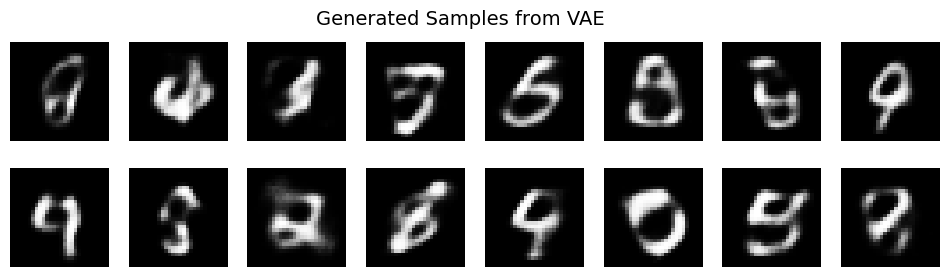

In [7]:
# 🧪 Simple VAE in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------------------------------
# 1. Define Encoder + Decoder
# -------------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mu
        self.fc22 = nn.Linear(400, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)   # mu, logvar

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + torch.exp(0.5*logvar) * eps

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))   # outputs in [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# -------------------------------
# 2. Define VAE Loss (ELBO)
# -------------------------------
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# -------------------------------
# 3. Load Data (MNIST)
# -------------------------------
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=128, shuffle=True)

# -------------------------------
# 4. Train VAE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
model.train()
for epoch in range(1, epochs+1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}")

# -------------------------------
# 5. Generate New Samples
# -------------------------------
model.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)        # sample from prior
    samples = model.decode(z).cpu()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].view(28, 28), cmap='gray')
    ax.axis("off")
plt.suptitle("Generated Samples from VAE", fontsize=14)
plt.show()


# ⚖️ Reconstruction Loss in VAEs: BCE vs. MSE

The reconstruction loss comes from the negative log-likelihood term:
$$
{L}_{\text{rec}}(x) = - \mathbb{E}_{z \sim q_\phi(z|x)} \big[ \log p_\theta(x \mid z) \big].
$$

Different choices of decoder likelihood → different reconstruction losses:

---

### 🔹 Bernoulli Likelihood → Binary Cross-Entropy (BCE)
- Assume each pixel is **Bernoulli-distributed**:
  $$
  p_\theta(x \mid z) = \text{Bernoulli}(\mu_\theta(z))
  $$
- Negative log-likelihood gives **binary cross-entropy**:
  - Good for binarized or \([0,1]\)-scaled images (MNIST).  
  - Often yields sharper results.  

---

### 🔹 Gaussian Likelihood → Mean Squared Error (MSE)
- Assume each pixel is **Gaussian with fixed variance**:
  $$
  p_\theta(x \mid z) = {N}(x \mid \mu_\theta(z), \sigma^2 I)
  $$
- Negative log-likelihood (ignoring constants) gives **MSE**:
  - Natural for continuous-valued data (e.g. natural images).  
  - Sometimes produces blurrier reconstructions.  

---

✅ Both are correct — the choice depends on the **data type** and the **likelihood assumption**.


In [ ]:
# 🧪 PyTorch Implementation of Both Losses

import torch.nn.functional as F

def reconstruction_loss_BCE(recon_x, x):
    """
    Bernoulli likelihood assumption:
    → Binary Cross-Entropy (BCE) loss
    """
    return F.binary_cross_entropy(
        recon_x,
        x.view(-1, 28*28),
        reduction='sum'
    )

def reconstruction_loss_MSE(recon_x, x):
    """
    Gaussian likelihood assumption:
    → Mean Squared Error (MSE) loss
    """
    return F.mse_loss(
        recon_x,
        x.view(-1, 28*28),
        reduction='sum'
    )

# Example usage inside training loop:
# recon, mu, logvar = model(data)
#
# BCE version:
# loss = reconstruction_loss_BCE(recon, data) + KLD
#
# MSE version:
# loss = reconstruction_loss_MSE(recon, data) + KLD


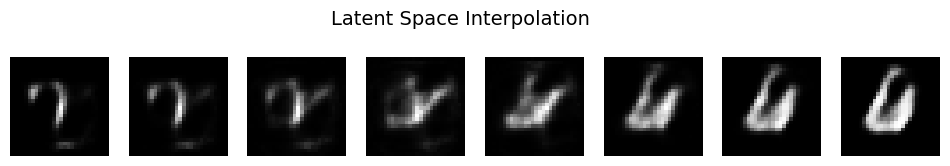

In [8]:
# 🌈 Latent Space Interpolation in VAE

def interpolate(mu1, mu2, steps=8):
    """Linearly interpolate between two latent vectors."""
    return torch.stack([mu1 * (1 - t) + mu2 * t for t in torch.linspace(0, 1, steps)])

model.eval()
with torch.no_grad():
    # Pick two random latent samples
    z1 = torch.randn(1, 20).to(device)
    z2 = torch.randn(1, 20).to(device)

    # Interpolate between them
    zs = interpolate(z1, z2, steps=8).to(device)

    # Decode to images
    imgs = model.decode(zs).cpu()

# Plot interpolation results
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(imgs), figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(imgs[i].view(28, 28), cmap='gray')
    ax.axis("off")
plt.suptitle("Latent Space Interpolation", fontsize=14)
plt.show()


![VAE](https://i.sstatic.net/GgS2y.png)

# 📊 VAE vs. Autoregressive Models (Side-by-Side)

| Aspect | Autoregressive Models | Variational Autoencoders (VAEs) |
|--------|-----------------------|--------------------------------|
| **Sampling** | Sequential, one step at a time → **slow, not parallelizable** | Parallel: draw latent \(z\) and decode in one shot → **fast** |
| **Error Propagation** | Errors **accumulate** across time steps | Reconstruction depends on latent \(z\) → **no accumulation** |
| **Distributional Assumptions** | Assumes conditional distribution is **time-invariant** in some order | Learns flexible latent variable model, no strict time-shift assumption |
| **Data Type** | Naturally suited for **discrete data** (tokens, text) | Works for both **continuous and discrete** data (e.g. images, audio, text) |
| **Representation** | Models dataset distribution directly, but **no compressed latent space** | Learns a **low-dimensional latent code** capturing key factors |
| **Generative Ability** | Good for sequential prediction, but weak at learning global structure | Good at capturing **global structure** and **meaningful latent factors** |
| **Intuition** | Predict the **next token** given history | Compress into latent \(z\), then **reconstruct / generate** data |


# 🌫️ The Curse of Blurriness in VAEs

---

## 🔍 Observation
- VAEs often generate **blurry images**, especially compared to GANs or diffusion models.  
![blur](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSfMkbCNR4tGcCJDDfpNgVEzzlwBHB6emQCReoDxyVhWB_tw7yKsgQ_8wukVdiGO15L1Zg&usqp=CAU)
---

## ❓ Why are VAE outputs blurry?

### 1. Reconstruction as an **average**
- Suppose our dataset has only two samples: $\{x_0, x_1\}$.  
- If we sample a latent point $z'$ in-between, the decoder must output something plausible.  
- With an optimized reconstruction loss (Gaussian likelihood), the optimal decoder output is:
$$
\mu_\theta(z') = \sum_i w_i x_i,
$$
where
$$
w_i = \frac{q_\phi(z' \mid x_i)}{\sum_j q_\phi(z' \mid x_j)}.
$$

- This is a **weighted average of training samples**.  
- The average of images (e.g. faces) looks **blurry**.

---

### 2. Gaussian likelihood assumption
- Decoder assumes:
$$
p_\theta(x \mid z) = {N}(x \mid \mu_\theta(z), \sigma^2 I).
$$
- The best estimate of the mean under MSE/Gaussian loss is the **average of all likely reconstructions**.  
- Averaging multiple plausible images = blur.  

---

### 3. Overlapping posteriors
- Encoder posteriors $q_\phi(z \mid x)$ for different samples overlap in latent space.  
- For any $z'$, the decoder sees contributions from multiple training points.  
- The weights $w_i$ are rarely one-hot → decoder averages across data.  

---

## 📌 Example
- "Average face of European parliament" = smooth, but blurry.  
- Same effect happens in VAEs because of Gaussian averaging.

---

## 🚨 Takeaway
- **Blurriness is fundamental to vanilla VAEs.**  
- It arises from:
  - Gaussian likelihood assumption, and  
  - Overlapping Gaussian posteriors.  
- Simply scaling up model size does **not** remove blur.  
- Advanced variants (e.g., **VQ-VAE, β-VAE, VAE-GAN**) try to address this issue.
